ベイズ統計の教科書p202、ベイズモデリングの世界p24、PP10/23

In [2]:
import numpy as np
from scipy import stats
from scipy.special import comb
import pymc as pm
from pymc.sampling.jax import sample_numpyro_nuts
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns
%matplotlib inline

/Users/shunta/py_venvs/py1/.venv1/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


花の個体を4つに分けてそれぞれ確率分布が違うとする

In [6]:
np.random.seed(123)
flowerNum = 80
flower_4 = int(flowerNum/4)
ovuleNum = 10
y1 = stats.bernoulli.rvs(p=0.2, size=(flower_4, ovuleNum))
y2 = stats.bernoulli.rvs(p=0.4, size=(flower_4, ovuleNum))
y3 = stats.bernoulli.rvs(p=0.6, size=(flower_4, ovuleNum))
y4 = stats.bernoulli.rvs(p=0.8, size=(flower_4, ovuleNum))

y_observed = np.concatenate([y1, y2, y3, y4])
y_frat = np.ravel(y)
print(y_observed.shape, y_frat.shape)

(80, 10) (800,)


379


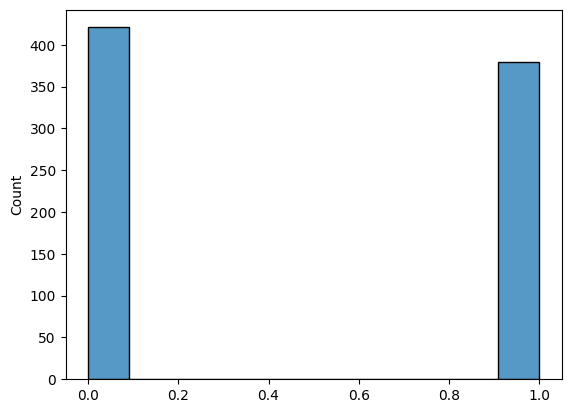

In [7]:
sns.histplot(y_frat, kde=False)
print(y_frat.sum())

Text(0, 0.5, 'flower number')

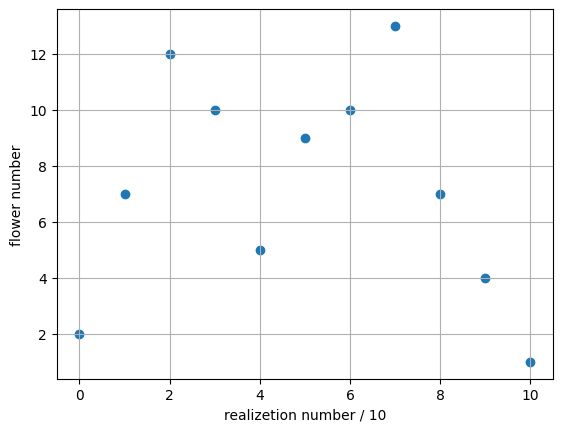

In [8]:
x = np.zeros(ovuleNum+1, dtype=int)
y_i = np.sum(y_observed, axis=1)

for i in range(ovuleNum+1):
    x[i] = np.count_nonzero(y_i==i)

plt.scatter(range(ovuleNum+1), x)
plt.grid(True)
plt.xlabel('realizetion number / 10')
plt.ylabel('flower number')

普通の(頻度論的な)統計モデル　\
すべての花の個体の結実確率が同じと仮定

0.4391495502648448 0.5083504497351552


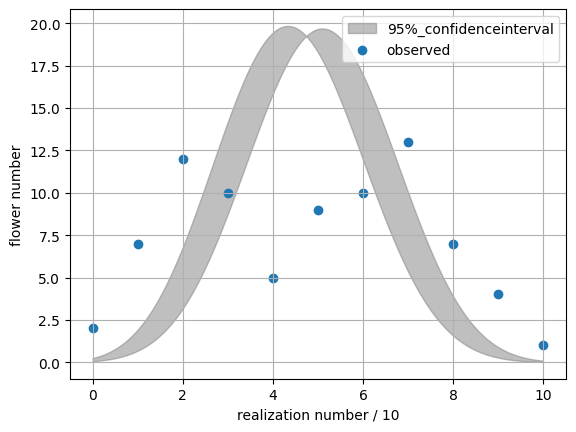

In [9]:
#二項分布の確率関数を書く
a = np.arange(0,ovuleNum,0.01)
def B(y_i, p):
    return(comb(10, y_i)*p**y_i*(1-p)**(10-y_i))
q_1 = y_frat.sum()/(flowerNum*ovuleNum)
q_95_bottom = q_1-1.96*np.sqrt(q_1*(1-q_1)/(flowerNum*ovuleNum))
q_95_top = q_1+1.96*np.sqrt(q_1*(1-q_1)/(flowerNum*ovuleNum))

plt.fill_between(a,flowerNum*B(a, q_95_bottom),flowerNum*B(a, q_95_top),color="grey",alpha=0.5, label="95%_confidenceinterval")

plt.scatter(range(ovuleNum+1), x, label="observed")
plt.grid(True)
plt.legend()
plt.xlabel('realization number / 10')
plt.ylabel('flower number')

print(q_95_bottom, q_95_top)

以降ベイズ統計学(MCMC)
$$
y_i \sim B(logistic(\beta + \alpha_i))  \\
\beta \sim U(-100,100) \\
\alpha_i \sim N(0,\sigma_i) \\
\sigma \sim U(0,100)
$$

In [10]:
with pm.Model() as model_f:
    model_f.add_coord('i', np.arange(0, flowerNum))
    #事前分布
    sigma = pm.Uniform('sigma', lower=0, upper=100)
    alpha_i = pm.Normal('alpha', mu=0, sigma=sigma, dims='i')
    beta = pm.Uniform('beta', lower=-100, upper=100)
    #目標分布
    pm.Binomial('y_i', n=ovuleNum, p=pm.math.sigmoid(alpha_i + beta), observed=y_i)

In [11]:
with model_f:
    trace_f = sample_numpyro_nuts(5000)

Compiling...
Compilation time =  0:00:03.628539
Sampling...


Compiling.. :   0%|          | 0/6000 [00:00<?, ?it/s]







Running chain 0:   0%|          | 0/6000 [00:04<?, ?it/s]


Running chain 0:   5%|▌         | 300/6000 [00:04<00:14, 385.55it/s]


Running chain 0:  20%|██        | 1200/6000 [00:05<00:02, 1624.02it/s]


Running chain 0:  35%|███▌      | 2100/6000 [00:05<00:01, 2721.62it/s]


Running chain 0:  50%|█████     | 3000/6000 [00:05<00:00, 3644.99it/s]


Running chain 0:  65%|██████▌   | 3900/6000 [00:05<00:00, 4432.44it/s]


Running chain 0:  80%|████████  | 4800/6000 [00:05<00:00, 5057.08it/s]


Running chain 3: 100%|██████████| 6000/6000 [00:05<00:00, 1037.03it/s]


Sampling time =  0:00:06.453165
Transforming variables...
Transformation time =  0:00:00.250901


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>]], dtype=object)

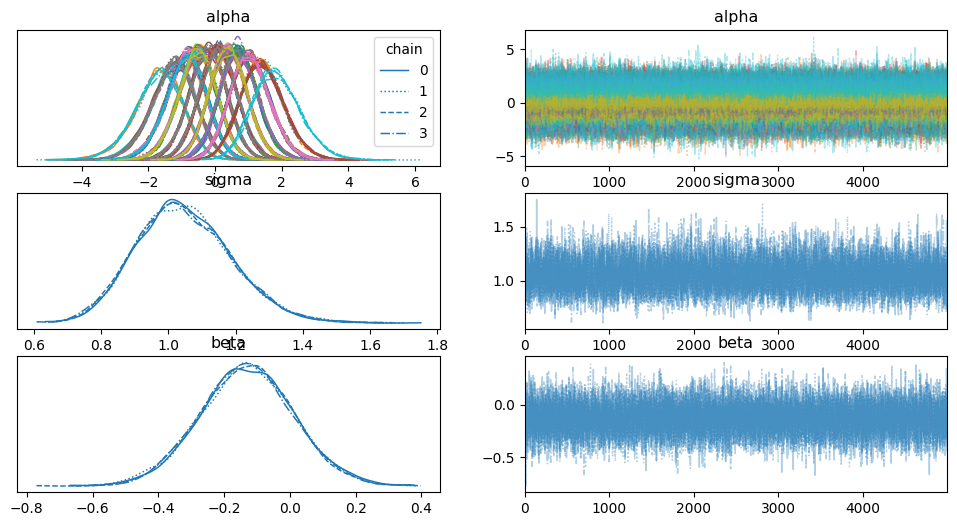

In [12]:
pm.plot_trace(trace_f, legend=True)

In [13]:
pm.summary(trace_f)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],-1.260,0.661,-2.535,-0.074,0.003,0.003,39071.0,14358.0,1.0
alpha[1],-1.700,0.726,-3.089,-0.354,0.004,0.003,32046.0,14371.0,1.0
alpha[2],-1.260,0.660,-2.501,-0.044,0.004,0.003,37697.0,12943.0,1.0
alpha[3],-0.875,0.607,-2.026,0.250,0.003,0.003,42376.0,14473.0,1.0
alpha[4],-0.882,0.614,-2.010,0.310,0.003,0.003,42762.0,13886.0,1.0
...,...,...,...,...,...,...,...,...,...
alpha[77],0.092,0.567,-0.989,1.157,0.003,0.005,44817.0,13410.0,1.0
alpha[78],0.400,0.567,-0.644,1.496,0.003,0.004,41135.0,14403.0,1.0
alpha[79],1.857,0.727,0.530,3.236,0.004,0.004,30316.0,13362.0,1.0
sigma,1.047,0.141,0.794,1.319,0.001,0.001,10323.0,13030.0,1.0


Sampling: [y_i]


Text(0.5, 0, 'realization number / 10')

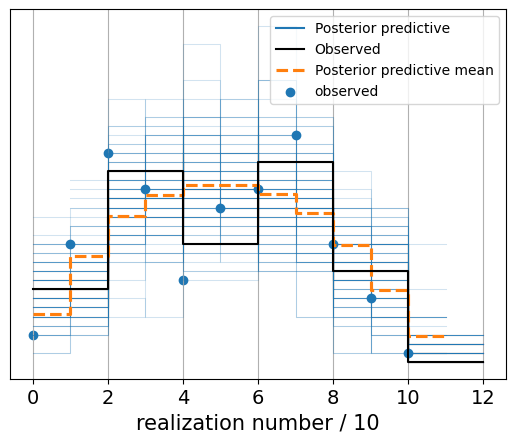

In [14]:
with model_f:
    #予測分布
    pm.sample_posterior_predictive(trace_f, extend_inferencedata=True)
    az.plot_ppc(trace_f, num_pp_samples=100, kind='kde', data_pairs={'y_i':'y_i'}, var_names=['y_i'])

plt.scatter(range(ovuleNum+1), x/80, label="observed")
plt.grid(True)
plt.legend()
plt.xlabel('realization number / 10')

